# Simple Model
The aim of this workbook it to take an extremely simplified version of the model (just debris) and then build the equations and solve for them to ensure that the model is working correctly before implementing.

In [1]:
import dill as pickle
import sympy as sp
import pandas as pd
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numba import jit, prange
import os   

In [2]:
with open(os.path.join(os.getcwd(), '../../scenario_properties-long.pkl'), 'rb') as f:
    scenario_properties = pickle.load(f)

In [18]:
# Lambdafiying the equations
symbols = scenario_properties.all_symbolic_vars

# Convert to symbols
print(len(symbols)) # Should be 320 for a 40, 8 matrix
print(symbols)

#equations_flattened = [scenario_properties.equations[i, j] for j in range(scenario_properties.equations.cols) for i in range(scenario_properties.equations.rows)]
drag_flattened = [scenario_properties.full_drag[i, j] for j in range(scenario_properties.full_drag.cols) for i in range(scenario_properties.full_drag.rows)]
#pmd_flattened = [scenario_properties.full_Cdot_PMD[i, j] for j in range(scenario_properties.full_Cdot_PMD.cols) for i in range(scenario_properties.full_Cdot_PMD.rows)]
#collisions_flattened = [scenario_properties.full_coll[i, j] for j in range(scenario_properties.full_coll.cols) for i in range(scenario_properties.full_coll.rows)]

# Convert equations to lambda functions
#equations = [sp.lambdify(symbols, eq, 'numpy') for eq in equations_flattened]
full_drag = [sp.lambdify(symbols, eq, 'numpy') for eq in drag_flattened]
#full_pmd = [sp.lambdify(symbols, eq, 'numpy') for eq in pmd_flattened]
# full_coll = [sp.lambdify(symbols, eq, 'numpy') for eq in collisions_flattened]

600
[S_148kg_1, S_148kg_2, S_148kg_3, S_148kg_4, S_148kg_5, S_148kg_6, S_148kg_7, S_148kg_8, S_148kg_9, S_148kg_10, S_148kg_11, S_148kg_12, S_148kg_13, S_148kg_14, S_148kg_15, S_148kg_16, S_148kg_17, S_148kg_18, S_148kg_19, S_148kg_20, S_148kg_21, S_148kg_22, S_148kg_23, S_148kg_24, S_148kg_25, S_148kg_26, S_148kg_27, S_148kg_28, S_148kg_29, S_148kg_30, S_148kg_31, S_148kg_32, S_148kg_33, S_148kg_34, S_148kg_35, S_148kg_36, S_148kg_37, S_148kg_38, S_148kg_39, S_148kg_40, S_750kg_1, S_750kg_2, S_750kg_3, S_750kg_4, S_750kg_5, S_750kg_6, S_750kg_7, S_750kg_8, S_750kg_9, S_750kg_10, S_750kg_11, S_750kg_12, S_750kg_13, S_750kg_14, S_750kg_15, S_750kg_16, S_750kg_17, S_750kg_18, S_750kg_19, S_750kg_20, S_750kg_21, S_750kg_22, S_750kg_23, S_750kg_24, S_750kg_25, S_750kg_26, S_750kg_27, S_750kg_28, S_750kg_29, S_750kg_30, S_750kg_31, S_750kg_32, S_750kg_33, S_750kg_34, S_750kg_35, S_750kg_36, S_750kg_37, S_750kg_38, S_750kg_39, S_750kg_40, S_1250kg_1, S_1250kg_2, S_1250kg_3, S_1250kg_4, S_125

In [5]:
full_lambda_flattened = []

for i in range(len(scenario_properties.full_lambda)):
    if scenario_properties.full_lambda[i] is not None:
        full_lambda_flattened.extend(scenario_properties.full_lambda[i])
    else:
        # Append None to the list, length of scenario_properties.n_shells
        full_lambda_flattened.extend([None]*scenario_properties.n_shells)

In [38]:
print(scenario_properties.species_names)
scenario_properties.full_drag[:, 8]

['S_148kg', 'S_750kg', 'S_1250kg', 'Su_260kg', 'Su_473kg', 'sns', 'N_0.00141372kg', 'N_0.567kg', 'N_6kg', 'N_148kg', 'N_260kg', 'N_473kg', 'N_750kg', 'N_1250kg', 'B']


Matrix([
[          -128.683816415849*N_6kg_1 + 128.976917882587*N_6kg_2],
[           -57.4616106953938*N_6kg_2 + 57.591896761431*N_6kg_3],
[          -29.0703333123375*N_6kg_3 + 29.1359486296783*N_6kg_4],
[          -15.3305671459187*N_6kg_4 + 15.3650146167596*N_6kg_5],
[           -8.7818218231715*N_6kg_5 + 8.80146611644399*N_6kg_6],
[          -5.02178224074003*N_6kg_6 + 5.03296556777707*N_6kg_7],
[          -2.86662816354697*N_6kg_7 + 2.87298373328529*N_6kg_8],
[          -1.70625635370556*N_6kg_8 + 1.71002257576129*N_6kg_9],
[          1.02969352343406*N_6kg_10 - 1.02743563102703*N_6kg_9],
[      -0.628805861648734*N_6kg_10 + 0.630181678330862*N_6kg_11],
[      -0.389314542528328*N_6kg_11 + 0.390162644947601*N_6kg_12],
[      -0.243838554281789*N_6kg_12 + 0.244367440170818*N_6kg_13],
[       -0.152721446033862*N_6kg_13 + 0.15305126812083*N_6kg_14],
[    -0.0964906418572937*N_6kg_14 + 0.0966981299164054*N_6kg_15],
[    -0.0636863556247657*N_6kg_15 + 0.0638227167411957*N_6kg_16],
[

In [32]:
x0_flattened = scenario_properties.x0.T.values.flatten()
times = np.array(scenario_properties.scen_times)

# Initial population needs to be in one columnn, so now the intiial population is in one. Species 1 is the first 40 rows, species 2 is the next 40 rows, etc.
def population_shell(t, N, full_lambda, equations):
    print(t)
    # Initialize the rate of change array
    dN_dt = np.zeros_like(N)
    # Iterate over each component in N
    for i in range(len(N)):
       
        # Compute and add the external modification rate, if applicable
        # Now using np.interp to calculate the increase
        # if full_lambda[i] is not None:
        #     increase = np.interp(t, times, full_lambda[i])
        #     # If increase is nan set to 0
        #     if np.isnan(increase):
        #         increase = 0
        #     else:
        #         dN_dt[i] += increase

        # Compute the intrinsic rate of change from the differential equation
        dN_dt[i] += equations[i](*N)
        #print(equations[i](*N))

    return dN_dt

output = solve_ivp(population_shell, [scenario_properties.scen_times[0], scenario_properties.scen_times[-1]], x0_flattened, 
                    args=(full_lambda_flattened, full_drag), 
                    t_eval=scenario_properties.scen_times, method='RK45', rtol=1e-6, atol=1e-6)

0.0
0.0002227721918063071
0.0006979002992798454
0.0010468504489197679
0.0027916011971193815
0.0031017791079104235
0.0034895014963992267
0.0034895014963992267
0.00013958005985596907
0.0002093700897839536
0.0005583202394238763
0.0006203558215820848
0.0006979002992798454
0.0006979002992798454
5.419996464440045e-05
8.129994696660067e-05
0.0002167998585776018
0.00024088873175289087
0.00027099982322200224
0.00027099982322200224
0.0003251997878664027
0.0003522997701886029
0.00048779968179960405
0.0005118885549748931
0.0005419996464440045
0.0005419996464440045
0.0006071078284500002
0.0006396619194529979
0.0008024323744679871
0.0008313693442484297
0.0008675405564739828
0.0008675405564739828
0.0009411042806114876
0.00097788614268024
0.0011617954530240022
0.0011944904415295598
0.001235359177161507
0.001235359177161507
0.001321598544731587
0.0013647182285166273
0.0015803166474418278
0.0016186452552507523
0.001666556015011908
0.001666556015011908
0.0017708228982228427
0.00182295633982831
0.00208362

KeyboardInterrupt: 

In [39]:
from sympy import symbols, simplify

# Assuming we have a list 'drag_expressions' containing symbolic expressions for the drag force
# on debris in each shell, indexed by the shell number.

# Create symbolic variables representing drag forces for each shell
N = 40  # assuming 40 shells
drag_symbols = symbols(f'N_6kg_1:N_6kg_{N+1}')  # This will create N_6kg1 to N_6kg40

# Replace 'drag_symbols' with the actual drag expressions if available
drag_expressions = drag_symbols  # Replace with your actual drag expressions

def check_decreasing_drag(drag_matrix):
    # Get the sum of coefficients for drag force for each shell
    drag_coefficients = [simplify(sum(exp.as_coefficients_dict().values())) for exp in drag_matrix]
    
    # Check if each sum of drag coefficients is less than the previous sum
    for i in range(1, len(drag_coefficients)):
        if drag_coefficients[i] >= drag_coefficients[i-1]:
            return False  # if not strictly decreasing, return False
    return True  # if all are strictly decreasing, return True

# Run the check
is_decreasing = check_decreasing_drag(drag_expressions)
print(f"The drag is {'strictly decreasing' if is_decreasing else 'not strictly decreasing'} across shells.")


The drag is not strictly decreasing across shells.


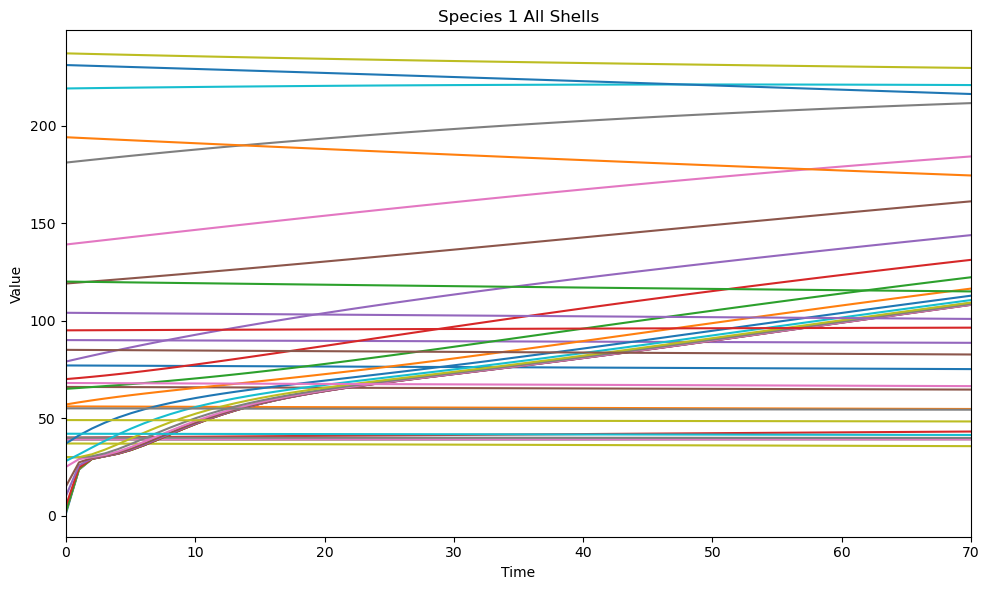

In [30]:
plt.figure(figsize=(10, 6))

# Assuming output.y has a shape of (n_variables, n_time_points)
# Loop over the first 40 variables (or species shells)
for i in range(351, 391):
    plt.plot(output.t, output.y[i], label=f'Species Shell {i+1}')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Species 1 All Shells')
plt.xlim(0, 70)

# Optional: Create a legend outside the plot
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()


In [ ]:
scenario_properties.collision_pairs[0].phi

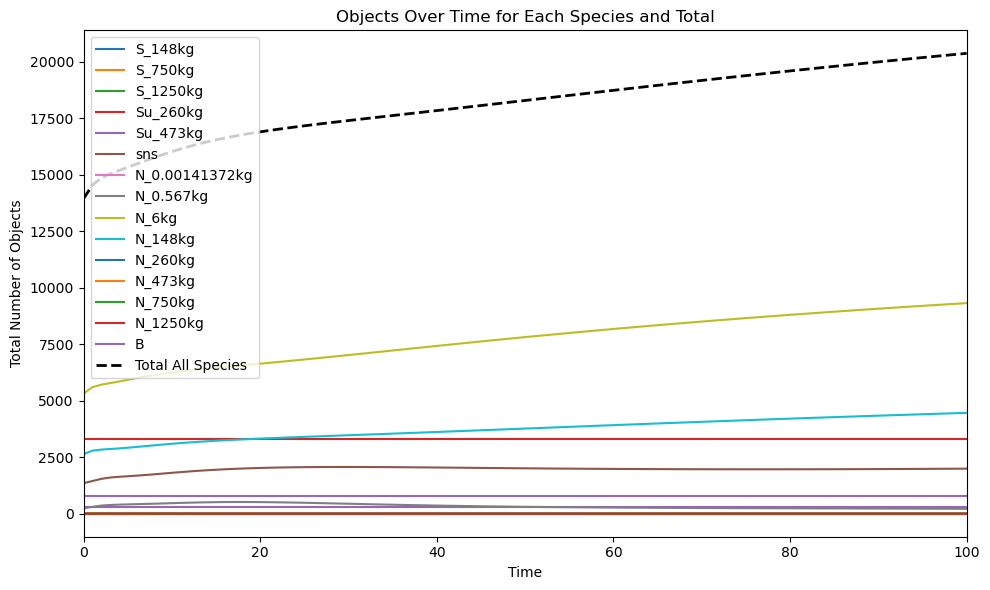

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming scenario_properties.species_names is available
species_names = scenario_properties.species_names

plt.figure(figsize=(10, 6))

# Assuming output.y's shape is (n_variables, n_time_points) and is ordered by species
num_species = len(species_names)
num_shells = 40  # Number of shells per species

# Initialize an array to hold the total number of objects at each time point
total_objects_all_species = np.zeros_like(output.t)

# Sum and plot for each species, using species names for labels
for i in range(num_species):
    start_idx = i * num_shells
    end_idx = start_idx + num_shells
    total_objects_per_species = np.sum(output.y[start_idx:end_idx, :], axis=0)  # Sum along the vertical axis
    plt.plot(output.t, total_objects_per_species, label=f'{species_names[i]}')
    
    # Add to the total objects count
    total_objects_all_species += total_objects_per_species

# Plot the total sum line
plt.plot(output.t, total_objects_all_species, label='Total All Species', color='k', linewidth=2, linestyle='--')

plt.xlabel('Time')
plt.ylabel('Total Number of Objects')
plt.title('Objects Over Time for Each Species and Total')
plt.xlim(0, max(output.t))
# Adjust the ylim based on the range of total_objects_all_species if necessary
# plt.ylim(0, np.max(total_objects_all_species) * 1.1)

plt.legend()
plt.tight_layout()
plt.show()


In [15]:
scenario_properties.species_names

['S_148kg',
 'S_750kg',
 'S_1250kg',
 'Su_260kg',
 'Su_473kg',
 'sns',
 'N_0.00141372kg',
 'N_0.567kg',
 'N_6kg',
 'N_148kg',
 'N_260kg',
 'N_473kg',
 'N_750kg',
 'N_1250kg',
 'B']

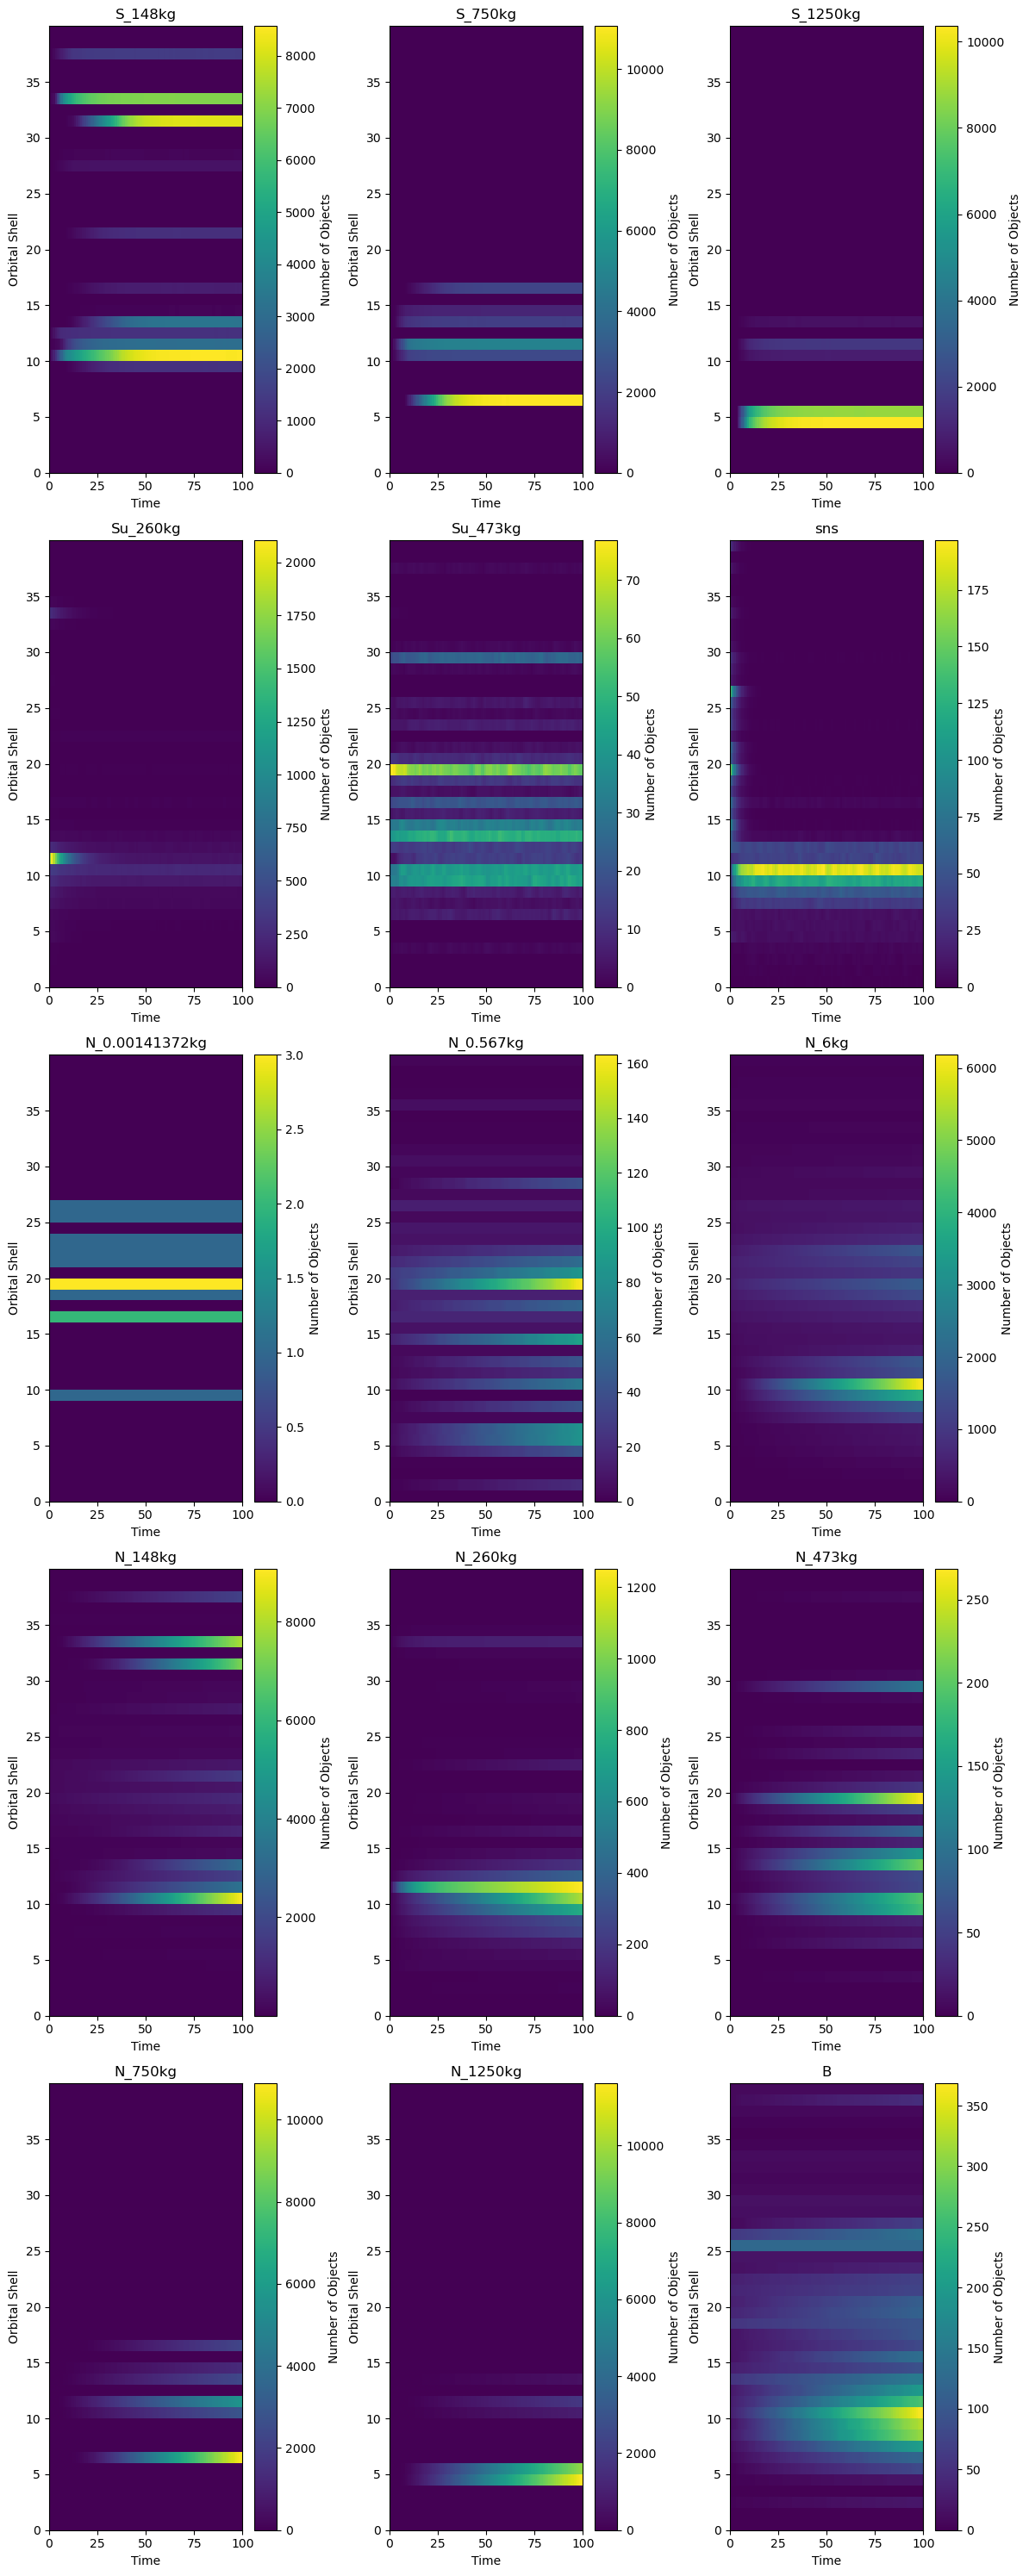

In [10]:
species_names = scenario_properties.species_names
num_species = len(species_names)
num_shells = 40  # Assuming this is constant for all species
n_time_points = len(output["t"])

# Determine the grid size based on the number of species
cols = 3  # Prefer a fixed number of columns
rows = np.ceil(num_species / cols).astype(int)

# Set up the figure and axes for the grid
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(12, rows * 6))

for i, species_name in enumerate(species_names):
    # Calculate the position in the grid
    row = i // cols
    col = i % cols
    if rows == 1:
        ax = axs[col]  # When there's only one row, `axs` is a 1D array
    else:
        ax = axs[row, col]

    # Extract the data for the current species across all shells
    start_idx = i * num_shells
    end_idx = start_idx + num_shells
    data_per_species = output["y"][start_idx:end_idx, :]
    
    # Plotting the heatmap
    cax = ax.imshow(data_per_species, aspect='auto', origin='lower',
                    extent=[output["t"][0], output["t"][-1], 0, num_shells],
                    interpolation='nearest')
    fig.colorbar(cax, ax=ax, label='Number of Objects')
    ax.set_xlabel('Time')
    ax.set_ylabel('Orbital Shell')
    ax.set_title(species_name)
    ax.set_xticks(np.linspace(output["t"][0], output["t"][-1], num=5))
    ax.set_yticks(np.arange(0, num_shells, 5))
    #ax.set_yticklabels([f'{alt:.0f}' for alt in scenario_properties.R0_km[::5]])

# Adjust layout and hide any unused axes
for i in range(num_species, rows*cols):
    if rows == 1:
        fig.delaxes(axs[i])
    else:
        axs.flatten()[i].set_visible(False)

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


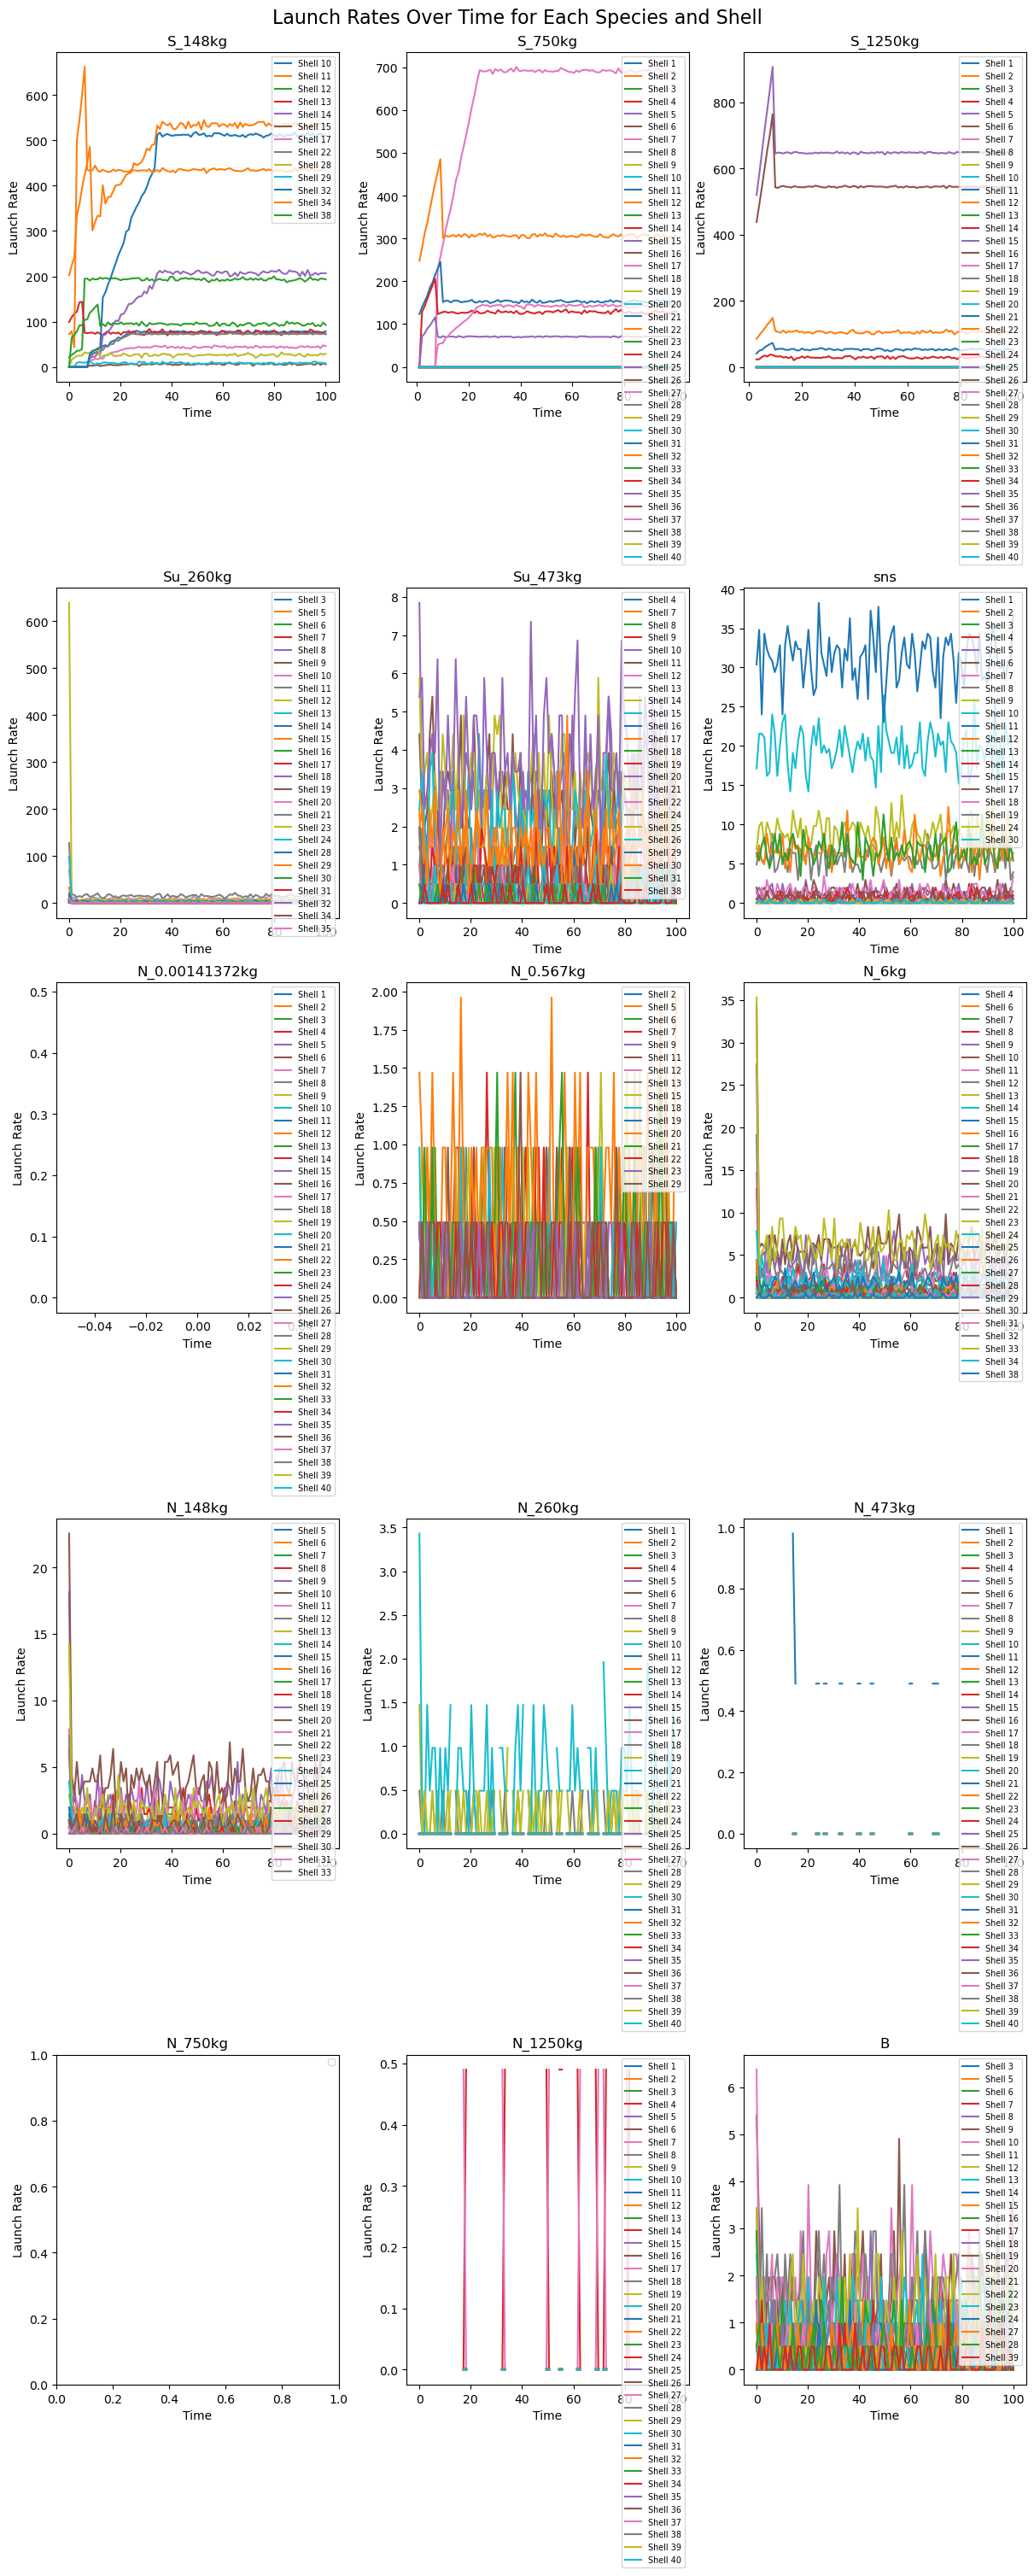

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming scenario_properties.species_names and scenario_properties.times are available
species_names = scenario_properties.species_names
times = scenario_properties.scen_times  # Time points for x-axis
num_species = len(species_names)
num_shells = 40  # Assuming this is constant for all species

# Determine the grid size based on the number of species
cols = 3  # Prefer a fixed number of columns
rows = np.ceil(num_species / cols).astype(int)

# Set up the figure and axes for the grid
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(12, rows * 6), constrained_layout=True)

# Iterate through each species and its corresponding data in full_lambda_flattened
for i in range(num_species):
    row = i // cols
    col = i % cols
    ax = axs[row, col] if rows > 1 else axs[col]
    
    # Assume each species' data is split across num_shells consecutive arrays in full_lambda_flattened
    start_idx = i * num_shells
    end_idx = start_idx + num_shells
    
    for shell_index in range(start_idx, end_idx):
        if full_lambda_flattened[shell_index] is not None:
            # Interpolate data for plotting
            interpolated_data = np.interp(times, times, full_lambda_flattened[shell_index])
            interpolated_data = interpolated_data / 2
            ax.plot(times, interpolated_data, label=f'Shell {shell_index - start_idx + 1}')
    
    ax.set_title(species_names[i])
    ax.set_xlabel('Time')
    ax.set_ylabel('Launch Rate')
    ax.legend(loc='upper right', fontsize='x-small')

# Hide any unused axes
for j in range(num_species * num_shells, rows * cols):
    if rows > 1:
        axs.flatten()[j].set_visible(False)
    else:
        axs[j].set_visible(False)

plt.suptitle('Launch Rates Over Time for Each Species and Shell', fontsize=16)
plt.show()

In [23]:
!pip install seaborn

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'd:\\programs\\anaconda\\envs\\fspsim\\lib\\site-packages\\numpy-1.23.5.dist-info\\METADATA'


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


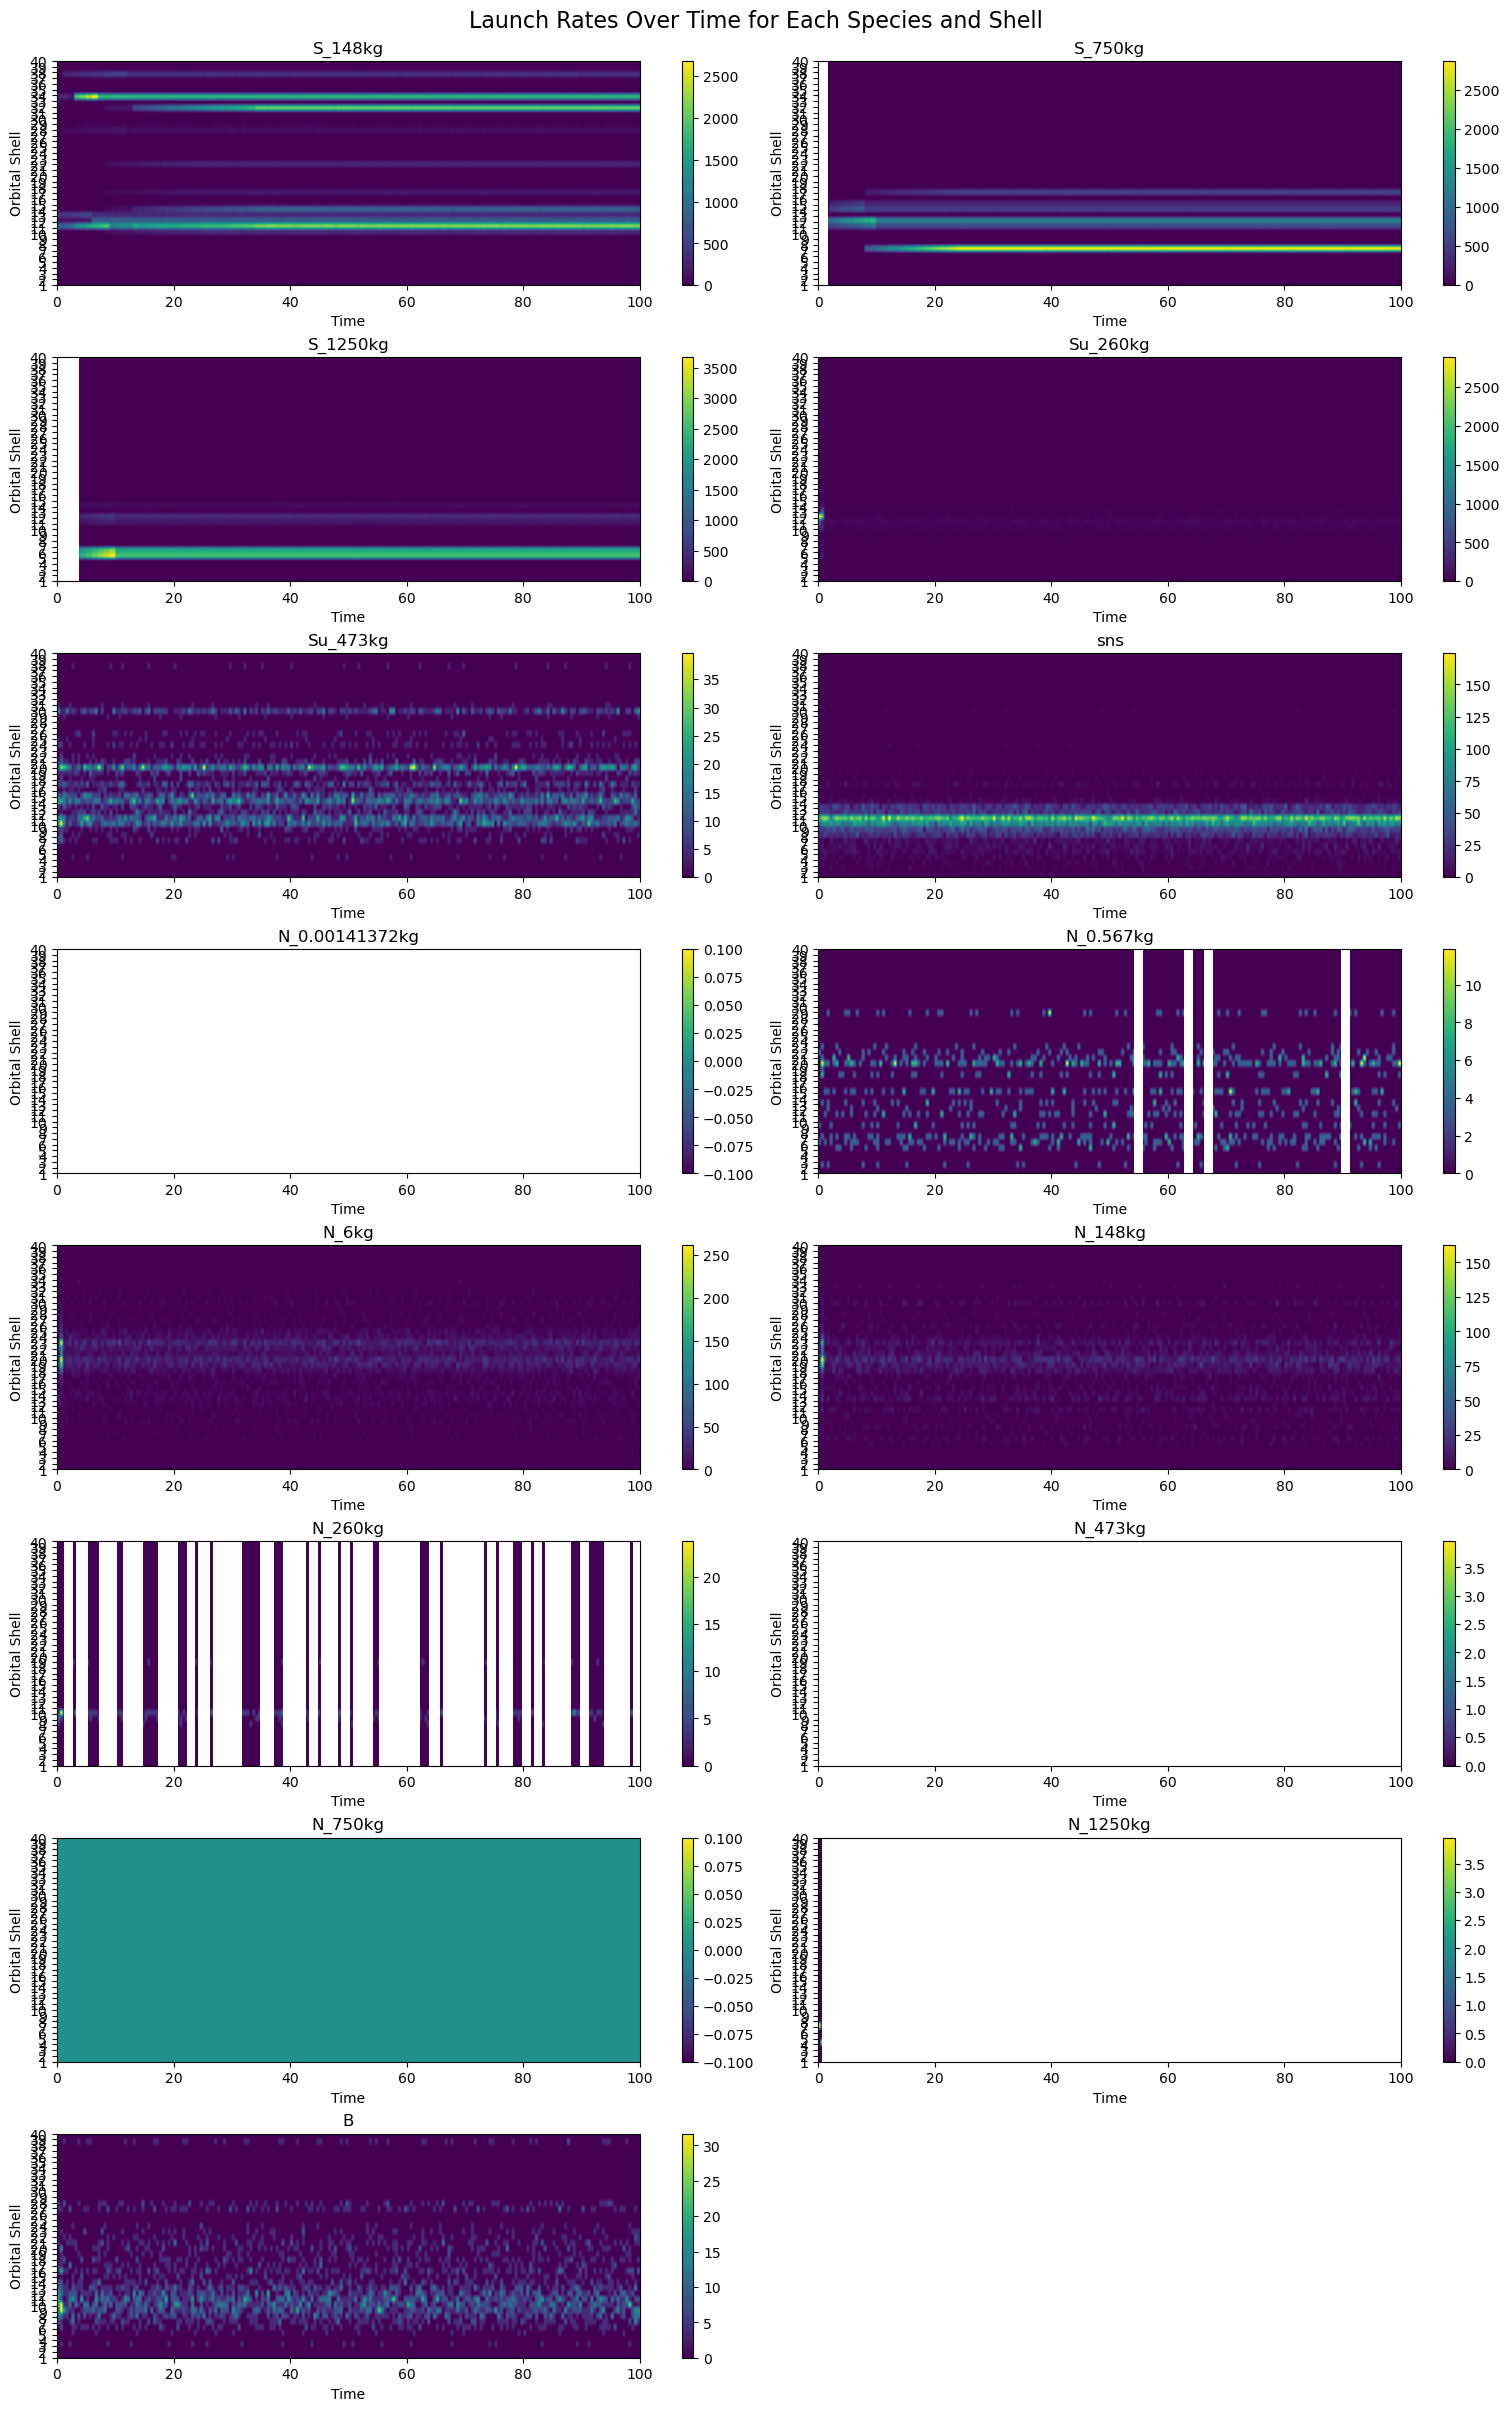

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming scenario_properties.species_names and scenario_properties.times are available
species_names = scenario_properties.species_names
times = scenario_properties.scen_times  # Time points for x-axis
num_species = len(species_names)
num_shells = 40  # Assuming this is constant for all species

# Determine the grid size based on the number of species
cols = 2  # Prefer a fixed number of columns
rows = np.ceil(num_species / cols).astype(int)

# Set up the figure and axes for the grid
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(15, rows * 3), constrained_layout=True)

for i, ax in enumerate(axs.flat):
    if i >= num_species:
        ax.set_visible(False)
        continue
    
    # Prepare an empty matrix to hold the interpolated data for all shells
    data_matrix = np.zeros((num_shells, len(times)))
    
    for shell_index in range(num_shells):
        index_in_lambda = i * num_shells + shell_index
        if full_lambda_flattened[index_in_lambda] is not None:
            # Call the interp1d function and fill the corresponding row in the data matrix
            data_matrix[shell_index, :] = full_lambda_flattened[index_in_lambda](times)
    
    # Plotting the heatmap for this species
    cax = ax.imshow(data_matrix, aspect='auto', cmap='viridis', origin='lower', extent=[times[0], times[-1], 1, num_shells])
    fig.colorbar(cax, ax=ax)
    
    ax.set_title(species_names[i])
    ax.set_xlabel('Time')
    ax.set_ylabel('Orbital Shell')
    ax.set_yticks(range(1, num_shells + 1))

plt.suptitle('Launch Rates Over Time for Each Species and Shell', fontsize=16)
plt.show()

In [337]:
scenario_properties.equations[:, 7][10]

0.000296369723523581*pi*B_11**2 + 1.15410199666787e-7*pi*B_11*N_0p00141372kg_11 + 4.04897918446949e-6*pi*B_11*N_0p567kg_11 + 0.000397542699065877*pi*B_11*N_1250kg_11 + 6.45629411723897e-5*pi*B_11*N_148kg_11 + 7.746048294236e-5*pi*B_11*N_260kg_11 + 0.00016204354768903*pi*B_11*N_473kg_11 + 4.72509985626051e-5*pi*B_11*N_6kg_11 + 0.000170354817509157*pi*B_11*N_750kg_11 + 0.000399670281399827*pi*B_11*S_1250kg_11 + 6.57267213099952e-5*pi*B_11*S_148kg_11 + 0.000176084934098102*pi*B_11*S_750kg_11 + 7.7686614925472e-5*pi*B_11*Su_260kg_11 + 0.000164804289612621*pi*B_11*Su_473kg_11 + 4.61786744753536e-5*pi*B_11*sns_11 - 3.55734960913629e-10*pi*N_0p00141372kg_11*N_0p567kg_11 + 4.58224963407711e-10*pi*N_0p00141372kg_11*N_148kg_11 - 2.4594274459668e-9*pi*N_0p567kg_11**2 + 3.66977865382173e-6*pi*N_0p567kg_11*N_1250kg_11 + 2.09057822701001e-7*pi*N_0p567kg_11*N_148kg_11 + 5.52646797329902e-7*pi*N_0p567kg_11*N_260kg_11 + 5.34230372776622e-6*pi*N_0p567kg_11*N_473kg_11 - 9.94980989872013e-11*pi*N_0p567kg_

In [357]:
u = 0
print(scenario_properties.collision_pairs[u].name)
scenario_properties.collision_pairs[u].eqs

species_pair(S_148kg, S_750kg)


Matrix([
[   -1.2035606185153e-17*pi*S_148kg_1*S_750kg_1,    -1.2035606185153e-17*pi*S_148kg_1*S_750kg_1, 0, 0, 0, 0,   8.58499789186963e-15*pi*S_148kg_1*S_750kg_1,   1.24087099768927e-15*pi*S_148kg_1*S_750kg_1,   8.06385614405251e-17*pi*S_148kg_1*S_750kg_1, 0, 0, 0, 0, 0, 0],
[  -1.19268209226723e-17*pi*S_148kg_2*S_750kg_2,   -1.19268209226723e-17*pi*S_148kg_2*S_750kg_2, 0, 0, 0, 0,   8.22115766199804e-15*pi*S_148kg_2*S_750kg_2,   1.43002582862841e-15*pi*S_148kg_2*S_750kg_2,   1.70553539194214e-16*pi*S_148kg_2*S_750kg_2, 0, 0, 0, 0, 0, 0],
[  -1.18195039241964e-17*pi*S_148kg_3*S_750kg_3,   -1.18195039241964e-17*pi*S_148kg_3*S_750kg_3, 0, 0, 0, 0,   8.29610980439347e-15*pi*S_148kg_3*S_750kg_3,   1.29541763009193e-15*pi*S_148kg_3*S_750kg_3,   1.38288195913098e-16*pi*S_148kg_3*S_750kg_3, 0, 0, 0, 0, 0, 0],
[  -1.17136288854394e-17*pi*S_148kg_4*S_750kg_4,   -1.17136288854394e-17*pi*S_148kg_4*S_750kg_4, 0, 0, 0, 0,   8.32136196021616e-15*pi*S_148kg_4*S_750kg_4,   1.24633011341075e-15*pi*S_

vpa("0.0000000026634048657623767960572085979065")

In [356]:
8.59582993743627e-05*pi

0.00027004596182956994

In [ ]:
vpa("0.00000000000002674748157354209746636668600453")